In [1]:
import numpy as np
import iris
from iris import cube
import iris.coord_categorisation
import iris.analysis.cartography
import glob
import warnings
from iris.util import equalise_attributes 
from iris.util import unify_time_units
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec as gspec
from matplotlib.lines import Line2D


### Define functions

In [2]:
### Becky CMIP6 functions

#
def combine_netCDF_model(directory, model):

    list_files = glob.glob(directory)
    list_files = np.array(list_files)
    newlist = np.sort(list_files)

    Cubelist = iris.cube.CubeList([])

    for i in range(0, len(newlist)):

        with warnings.catch_warnings():
            warnings.simplefilter('ignore', FutureWarning)
            warnings.simplefilter('ignore', UserWarning)

            cube = iris.load_cube(newlist[i])
            Cubelist.append(cube)

    unify_time_units(Cubelist)
    equalise_attributes(Cubelist)

    new_cube = Cubelist.concatenate_cube()

    return new_cube

#
def combine_netCDF_cmip6(directory, model):

    list_files = glob.glob(directory)
    list_files = np.array(list_files)
    newlist = np.sort(list_files)

    Cubelist = iris.cube.CubeList([])

    for i in range(0, len(newlist)):

        with warnings.catch_warnings():
            warnings.simplefilter('ignore', FutureWarning)
            warnings.simplefilter('ignore', UserWarning)
            
            cube = iris.load_cube(newlist[i])

            cube.coord('latitude').attributes = {}
            cube.coord('longitude').attributes = {}  
            if i == 0:
                metadata1 = cube.metadata
            else:
                cube.metadata = metadata1
            
            if model=='IPSL-CM6A-LR' or model=='CNRM-ESM2-1':
                 cube.coord('latitude').guess_bounds()
                 cube.coord('longitude').guess_bounds()
         
            # CESM2 bound issue fix
            if (model=='CESM2') & (i==0):
                lat_data = cube.coord('latitude').points
                lon_data = cube.coord('longitude').points
                lat_bounds = cube.coord('latitude').bounds
                lon_bounds = cube.coord('longitude').bounds
            elif (model=='CESM2') & (i>0):
                cube.coord('latitude').points = lat_data
                cube.coord('longitude').points = lon_data
                cube.coord('latitude').bounds = lat_bounds
                cube.coord('longitude').bounds = lon_bounds
    
            if model=='IPSL-CM6A-LR':
                cube.coord('time').attributes.pop('time_origin')
            
            Cubelist.append(cube)

    unify_time_units(Cubelist)
    equalise_attributes(Cubelist)

    for cube in Cubelist:
        lon_bounds = Cubelist[0].coord('longitude').bounds
        cube.coord('longitude').bounds = lon_bounds

    for i, cube in enumerate(Cubelist):
        if cube.coord('time').units == Cubelist[0].coord('time').units:
            pass
        else:
            print(i)
            
    new_cube = Cubelist.concatenate_cube()

    return new_cube

#
def open_netCDF(new_cube):

    iris.coord_categorisation.add_year(new_cube, 'time', name='year') # add year
    iris.coord_categorisation.add_month(new_cube, 'time', name ='month') # add month
    iris.coord_categorisation.add_month(new_cube, 'time', name ='decade') # add month

    return new_cube

#
def annual_average(new_cube):

    annual_average_cube = new_cube.aggregated_by('year', iris.analysis.MEAN)

    return annual_average_cube

#
def global_total_percentage(cubein, landfrac=None, latlon_cons=None):

    cube = cubein.copy()
    if landfrac is not None:
        try:
            cube.data = cube.data * (landfrac.data/100)
        except:
            landfrac = landfrac.extract(latlon_cons)
            cube.data = cube.data * (landfrac.data/100)

    if cube.coord('latitude').bounds is not None:
        pass
    else:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()

    weights = iris.analysis.cartography.area_weights(cube)

    cube_areaweight = cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights=weights)/1e12

    return cube_areaweight

#
def area_average(cube, region):

    lon1, lon2, lat1, lat2 = region[0], region[1], region[2], region[3] 
    cube = cube.intersection(longitude=(lon1, lon2),latitude=(lat1, lat2))

    weights = iris.analysis.cartography.area_weights(cube)
    cube = cube.collapsed(['latitude','longitude'], iris.analysis.MEAN, weights=weights)

    return cube


# def centered_moving_average(data, average_length):
#     if average_length < 1:
#         raise ValueError("average_length must be >= 1")
#     if average_length > len(data):
#         raise ValueError("average_length larger than data length")
    
#     kernel = np.ones(average_length) / average_length
#     rolling_avg = np.convolve(data, kernel, mode='valid')

#     return rolling_avg
def centered_moving_average(data, window=20):
    if window % 2 != 0:
        raise ValueError("This function expects an even window size.")
        
    half_window = window // 2

    # Pad the array on both sides
    padded = np.pad(data, (half_window, half_window), mode='edge')
    
    # Compute moving average using convolution
    kernel = np.ones(window) / window
    smoothed = np.convolve(padded, kernel, mode='valid')
    
    return smoothed


def clean_and_convert(x):
    if isinstance(x, (bytes, np.bytes_)):
        x = x.decode()
    x = x.strip("'")  # remove surrounding single quotes
    try:
        return float(x)
    except ValueError:
        return np.nan

### Read model data

Calculations with carbon stocks

In [ ]:
import warnings
warnings.filterwarnings("ignore")
### BGC-COU approach with T* = 0, carbon stocks (Arora et al., 2020)

# CO2 array
co2_array = np.zeros((150))
for i in range(0, 150):
        if i == 0:
                co2_array[i] = 285
        else:
            co2_array[i] = co2_array[i-1]*1.01

# C4MIP simulations: '1pctCO2' (COU), '1pctCO2-bgc' (BGC), '1pctCO2-rad' (RAD)

# CMIP6 models
cmip6_models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-ESM2-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL', 'EC-Earth3-CC', 'CMCC-ESM2']
n_models = len(cmip6_models)

cmip6_beta_4xCO2 = np.zeros((len(cmip6_models)))
cmip6_gamma_4xCO2 = np.zeros((len(cmip6_models)))

# CMIP6 models loop
for model_i in range(n_models):
        model = cmip6_models[model_i]
        print(model)

        ### read model data
        # land fraction
        if model == 'EC-Earth3-CC':
                model_update = 'EC-Earth3'
                landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_'+model_update+'_historical*', model)
        else:
                landfraction = combine_netCDF_model('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/sftlf_fx_'+model+'_historical*', model)


        # BGC Land Carbon (cLand)
        if model == 'UKESM1-0-LL':
                # cVeg
                cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cVeg_Lmon_'+model+'_1pctCO2-bgc*', model)
                cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
                cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
                cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cVeg_bgc_data = cVeg_bgc_cube.data
                # cSoil
                cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cSoil_Emon_'+model+'_1pctCO2-bgc*', model)
                cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
                cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
                cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cSoil_bgc_data = cSoil_bgc_cube.data
                # 
                cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data

                time_dimension = cVeg_bgc_cube.coord('year').points
        #elif model == 'BCC-CSM2-MR' or model == 'MIROC-ES2L':
        elif model == 'BCC-CSM2-MR' or model == 'MIROC-ES2L' or model == 'ACCESS-ESM1-5' or model == 'CanESM5' or model == 'CESM2' or model == 'GFDL-ESM4' or model == 'IPSL-CM6A-LR' or model == 'MPI-ESM1-2-LR' or model == 'NorESM2-LM':
                # cVeg
                cVeg_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cVeg_Lmon_'+model+'_1pctCO2-bgc*', model)
                cVeg_bgc_cube = open_netCDF(cVeg_bgc_cube)
                cVeg_bgc_cube = annual_average(cVeg_bgc_cube)
                cVeg_bgc_cube = global_total_percentage(cVeg_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cVeg_bgc_data = cVeg_bgc_cube.data
                # cSoil
                cSoil_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cSoil_Emon_'+model+'_1pctCO2-bgc*', model)
                cSoil_bgc_cube = open_netCDF(cSoil_bgc_cube)
                cSoil_bgc_cube = annual_average(cSoil_bgc_cube)
                cSoil_bgc_cube = global_total_percentage(cSoil_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cSoil_bgc_data = cSoil_bgc_cube.data 
                # cLitter
                cLitter_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cLitter_Lmon_'+model+'_1pctCO2-bgc*', model)
                cLitter_bgc_cube = open_netCDF(cLitter_bgc_cube)
                cLitter_bgc_cube = annual_average(cLitter_bgc_cube)
                cLitter_bgc_cube = global_total_percentage(cLitter_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cLitter_bgc_data = cLitter_bgc_cube.data
                # 
                cLand_bgc_data = cVeg_bgc_data + cSoil_bgc_data + cLitter_bgc_data

                # Time dimension
                if model == 'ACCESS-ESM1-5':
                        time_dimension = cVeg_bgc_cube.coord('year').points
                        time_dimension = time_dimension - 100
                else:
                        time_dimension = cVeg_bgc_cube.coord('year').points
                
        else:
                # cLand
                cLand_bgc_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cLand_Emon_'+model+'_1pctCO2-bgc*', model)
                cLand_bgc_cube = open_netCDF(cLand_bgc_cube)
                cLand_bgc_cube = annual_average(cLand_bgc_cube)
                cLand_bgc_cube = global_total_percentage(cLand_bgc_cube, landfrac=landfraction, latlon_cons=None)
                cLand_bgc_data = cLand_bgc_cube.data

                time_dimension = cLand_bgc_cube.coord('year').points

        # COU Land Carbon (cLand)
        if model == 'BCC-CSM2-MR' or model == 'NorESM2-LM':
                # cVeg
                cVeg_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cVeg_Lmon_'+model+'_1pctCO2_*', model)
                cVeg_cou_cube = open_netCDF(cVeg_cou_cube)
                cVeg_cou_cube = annual_average(cVeg_cou_cube)
                cVeg_cou_cube = global_total_percentage(cVeg_cou_cube, landfrac=landfraction, latlon_cons=None)
                cVeg_cou_data = cVeg_cou_cube.data
                # cSoil
                cSoil_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cSoil_Emon_'+model+'_1pctCO2_*', model)
                cSoil_cou_cube = open_netCDF(cSoil_cou_cube)
                cSoil_cou_cube = annual_average(cSoil_cou_cube)
                cSoil_cou_cube = global_total_percentage(cSoil_cou_cube, landfrac=landfraction, latlon_cons=None)
                cSoil_cou_data = cSoil_cou_cube.data 
                # cLitter
                cLitter_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cLitter_Lmon_'+model+'_1pctCO2_*', model)
                cLitter_cou_cube = open_netCDF(cLitter_cou_cube)
                cLitter_cou_cube = annual_average(cLitter_cou_cube)
                cLitter_cou_cube = global_total_percentage(cLitter_cou_cube, landfrac=landfraction, latlon_cons=None)
                cLitter_cou_data = cLitter_cou_cube.data
                # 
                cLand_cou_data = cVeg_cou_data + cSoil_cou_data + cLitter_cou_data
        else:
                # cLand
                cLand_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/cLand_Emon_'+model+'_1pctCO2_*', model)
                cLand_cou_cube = open_netCDF(cLand_cou_cube)
                cLand_cou_cube = annual_average(cLand_cou_cube)
                cLand_cou_cube = global_total_percentage(cLand_cou_cube, landfrac=landfraction, latlon_cons=None)
                cLand_cou_data = cLand_cou_cube.data

        # Temperature (tas)
        tas_cou_cube = combine_netCDF_cmip6('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/tas_Amon_'+model+'_1pctCO2_*', model)
        tas_cou_cube = open_netCDF(tas_cou_cube)
        tas_cou_cube = annual_average(tas_cou_cube)
        tas_cou_cube = area_average(tas_cou_cube - 273.15, [0, 360, -90,  90])
        tas_cou_data = tas_cou_cube.data
        tas_cou_data = centered_moving_average(tas_cou_data, 20)

        ### calculate beta and gamma land
        # beta
        dC_bgc = cLand_bgc_data[139] - cLand_bgc_data[0]
        dCo2 = co2_array[139] - co2_array[0]
        beta = dC_bgc/dCo2

        # gamma
        dC_cou = cLand_cou_data[139] - cLand_cou_data[0]
        dT_cou = tas_cou_data[139] - tas_cou_data[0]
        dC_res = dC_cou - dC_bgc
        gamma = dC_res/dT_cou

        print('4xCO2 T*=0', model, beta, gamma)

        # saving
        cmip6_beta_4xCO2[model_i] = beta
        cmip6_gamma_4xCO2[model_i] = gamma
        #np.save('saved_data/cmip6_beta_4xCO2.npy', cmip6_beta.data)
        #np.save('saved_data/cmip6_gamma_4xCO2.npy', cmip6_gamma.data)

        #np.save('saved_data/cmip6_'+model+'_T_COU.npy', tas_cou_data.data)
        #np.save('saved_data/cmip6_'+model+'_co2.npy', co2_array.data)
        #np.save('saved_data/cmip6_'+model+'_cLand_COU.npy', cLand_cou_data.data)
        #np.save('saved_data/cmip6_'+model+'_cLand_BGC.npy', cLand_bgc_data.data)
        #np.save('saved_data/cmip6_timedimension.npy', time_dimension.data)



ACCESS-ESM1-5


KeyboardInterrupt: 

Calculations with carbon fluxes

In [10]:
cfluxes = False

In [ ]:
if cfluxes:

        ### BGC-COU approach with T* = 0, carbon fluxes (Arora et al., 2020)

        # CO2 array
        co2_array = np.zeros((150))
        for i in range(0, 150):
                if i == 0:
                        co2_array[i] = 285
                else:
                        co2_array[i] = co2_array[i-1]*1.01

        # C4MIP simulations: '1pctCO2' (COU), '1pctCO2-bgc' (BGC), '1pctCO2-rad' (RAD)

        # CMIP6 models
        cmip6_models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-ESM2-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL', 'EC-Earth3-CC', 'CMCC-ESM2']
        n_models = len(cmip6_models)

        cmip6_beta_method2 = np.zeros((len(cmip6_models)))
        cmip6_gamma_method2 = np.zeros((len(cmip6_models)))

        # CMIP6 models loop
        for model_i in range(n_models):
                model = cmip6_models[model_i]
                print(model)

                # land fraction
                if model == 'EC-Earth3-CC':
                        model_update = 'EC-Earth3'
                        landfraction = combine_netCDF_model('/Volumes/Extreme SSD/DATA/cmip6_data/sftlf_fx_'+model_update+'_historical*', model)
                else:
                        landfraction = combine_netCDF_model('/Volumes/Extreme SSD/DATA/cmip6_data/sftlf_fx_'+model+'_historical*', model)

                # BGC fluxes
                if model == 'BCC-CSM2-MR':
                        # nep
                        flux_bgc_cube = combine_netCDF_cmip6('/Volumes/Extreme SSD/DATA/CMIP_1pctCO2-bgc/nep_Emon_'+model+'_1pctCO2-bgc*', model)
                        flux_bgc_cube = open_netCDF(flux_bgc_cube)
                        flux_bgc_cube = annual_average(flux_bgc_cube)
                        flux_bgc_cube = global_total_percentage(flux_bgc_cube, landfrac=landfraction, latlon_cons=None)
                        flux_bgc_data = flux_bgc_cube.data*86400.*360.
                elif model == 'CanESM5' or model == 'CNRM-ESM2-1' or model == 'UKESM1-0-LL' or model == 'CMCC-ESM2':
                        # netAtmosLandCO2Flux
                        flux_bgc_cube = combine_netCDF_cmip6('/Volumes/Extreme SSD/DATA/CMIP_1pctCO2-bgc/netAtmosLandCO2Flux_Emon_'+model+'_1pctCO2-bgc*', model)
                        flux_bgc_cube = open_netCDF(flux_bgc_cube)
                        flux_bgc_cube = annual_average(flux_bgc_cube)
                        flux_bgc_cube = global_total_percentage(flux_bgc_cube, landfrac=landfraction, latlon_cons=None)
                        flux_bgc_data = flux_bgc_cube.data*86400.*360.
                else:
                        # nbp
                        flux_bgc_cube = combine_netCDF_cmip6('/Volumes/Extreme SSD/DATA/CMIP_1pctCO2-bgc/nbp_Lmon_'+model+'_1pctCO2-bgc*', model)
                        flux_bgc_cube = open_netCDF(flux_bgc_cube)
                        flux_bgc_cube = annual_average(flux_bgc_cube)
                        flux_bgc_cube = global_total_percentage(flux_bgc_cube, landfrac=landfraction, latlon_cons=None)
                        flux_bgc_data = flux_bgc_cube.data*86400.*360.


                # COU fluxes
                if model == 'BCC-CSM2-MR':
                        # nep
                        flux_cou_cube = combine_netCDF_cmip6('/Volumes/Extreme SSD/DATA/CMIP_1pctCO2/nep_Emon_'+model+'_1pctCO2*', model)
                        flux_cou_cube = open_netCDF(flux_cou_cube)
                        flux_cou_cube = annual_average(flux_cou_cube)
                        flux_cou_cube = global_total_percentage(flux_cou_cube, landfrac=landfraction, latlon_cons=None)
                        flux_cou_data = flux_cou_cube.data*86400.*360.
                elif model == 'CNRM-ESM2-1' or model == 'EC-Earth3-CC':
                        # netAtmosLandCO2Flux
                        flux_cou_cube = combine_netCDF_cmip6('/Volumes/Extreme SSD/DATA/CMIP_1pctCO2/netAtmosLandCO2Flux_Emon_'+model+'_1pctCO2*', model)
                        flux_cou_cube = open_netCDF(flux_cou_cube)
                        flux_cou_cube = annual_average(flux_cou_cube)
                        flux_cou_cube = global_total_percentage(flux_cou_cube, landfrac=landfraction, latlon_cons=None)
                        flux_cou_data = flux_cou_cube.data*86400.*360.
                else:
                        # nbp
                        flux_cou_cube = combine_netCDF_cmip6('/Volumes/Extreme SSD/DATA/CMIP_1pctCO2/nbp_Lmon_'+model+'_1pctCO2*', model)
                        flux_cou_cube = open_netCDF(flux_cou_cube)
                        flux_cou_cube = annual_average(flux_cou_cube)
                        flux_cou_cube = global_total_percentage(flux_cou_cube, landfrac=landfraction, latlon_cons=None)
                        flux_cou_data = flux_cou_cube.data*86400.*360.

                # Temperature (tas)
                tas_cou_cube = combine_netCDF_cmip6('/Volumes/Extreme SSD/DATA/CMIP_1pctCO2/tas_Amon_'+model+'_1pctCO2*', model)
                tas_cou_cube = open_netCDF(tas_cou_cube)
                tas_cou_cube = annual_average(tas_cou_cube)
                tas_cou_cube = area_average(tas_cou_cube - 273.15, [0, 360, -90,  90])
                tas_cou_data = tas_cou_cube.data
                tas_cou_data = centered_moving_average(tas_cou_data, 20)


                # beta
                dC_bgc = np.sum(flux_bgc_data)
                print(dC_bgc)
                dCo2 = co2_array[139] - co2_array[0]
                beta = dC_bgc/dCo2

                # gamma
                dC_cou = np.sum(flux_cou_data)
                dT_cou = tas_cou_data[139] - tas_cou_data[0]
                dC_res = dC_cou - dC_bgc
                gamma = dC_res/dT_cou

                print('4xCO2 T*=0', model, beta, gamma)

                # saving
                cmip6_beta_method2[model_i] = beta
                cmip6_gamma_method2[model_i] = gamma
                #np.save('saved_data/cmip6_beta_4xCO2_flux.npy', cmip6_beta_method2.data)
                #np.save('saved_data/cmip6_gamma_4xCO2_flux.npy', cmip6_gamma_method2.data)

                #np.save('saved_data/cmip6_'+model+'_flux_COU.npy', flux_cou_data.data)
                #np.save('saved_data/cmip6_'+model+'_flux_BGC.npy', flux_bgc_data.data)
        

Load Arora et al. (2020) data for comparison

In [ ]:
### Load Arora et al. (2020) data for comparison

# CMIP6 models
arora_models = ['ACCESS-ESM1.5', 'BCC', 'CanESM5', 'CESM2', 'CNRM-ESM2.1', 'GFDL', 'IPSL', 'JAMSTEC', 'MPIESM', 'NorESM2LM', 'UKESM']
n_models = len(arora_models)

# CMIP6 models loop
for model_j in range(n_models):
        model = arora_models[model_j]
        print(model)

        cou_data = np.genfromtxt('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/c4mip_cmip6_ascii_files_11_models/'+model+'/'+model+'_1pc_COU.txt', names=True, dtype=None, encoding=None)
        bgc_data = np.genfromtxt('/Users/nste/Documents/entra/projects/d60_TCREassess/d60.data/CMIP6/CMIP6/c4mip_cmip6_ascii_files_11_models/'+model+'/'+model+'_1pc_BGC.txt', names=True, dtype=None, encoding=None)

        arora_st_cou = cou_data['ST']
        arora_land_cou = cou_data['LA_CO2_FLUX']
        arora_live_cou = cou_data['CLIVE']
        arora_dead_cou = cou_data['CDEAD']
        arora_landpool_cou = arora_live_cou + arora_dead_cou

        arora_co2_bgc = bgc_data['CO2']
        arora_land_bgc = bgc_data['LA_CO2_FLUX']
        arora_l_bgc = bgc_data['CLIVE']
        arora_d_bgc = bgc_data['CDEAD']

        if model == 'CNRM-ESM2.1':
                arora_l_bgc = np.vectorize(clean_and_convert)(arora_l_bgc)
                arora_d_bgc = np.vectorize(clean_and_convert)(arora_d_bgc)

        arora_live_bgc = np.ma.masked_array(arora_l_bgc, mask=np.isnan(arora_l_bgc))
        arora_dead_bgc = np.ma.masked_array(arora_d_bgc, mask=np.isnan(arora_d_bgc))
        arora_landpool_bgc = arora_live_bgc + arora_dead_bgc
        # print(arora_landpool_bgc)

        if model == 'UKESM':
                arora_st_cou = arora_st_cou - 273.15

        if model == 'ACCESS-ESM1.5' or model == 'BCC' or model =='MPIESM' or model == 'NorESM2LM' or model == 'UKESM':
                arora_land_cou = arora_land_cou * -1

        # note: model naming changed here from arora_models to cmip6_models for consistency
        #np.save('saved_data/arora_'+cmip6_models[model_j]+'_st_cou.npy', arora_st_cou)
        #np.save('saved_data/arora_'+cmip6_models[model_j]+'_land_cou.npy', arora_land_cou)
        #np.save('saved_data/arora_'+cmip6_models[model_j]+'_landpool_cou.npy', arora_landpool_cou)

        #np.save('saved_data/arora_'+cmip6_models[model_j]+'_co2_bgc.npy', arora_co2_bgc)
        #np.save('saved_data/arora_'+cmip6_models[model_j]+'_land_bgc.npy', arora_land_bgc)
        #np.save('saved_data/arora_'+cmip6_models[model_j]+'_landpool_bgc.npy', arora_landpool_bgc.data)



ACCESS-ESM1.5
BCC
CanESM5
CESM2
CNRM-ESM2.1
GFDL
IPSL
JAMSTEC
MPIESM
NorESM2LM
UKESM


In [15]:
### T timeseries plots

# Set up subplot figure
fig = plt.figure(1, figsize=(68,54))
gs = gspec.GridSpec(3, 4, figure=fig, width_ratios=[1, 1, 1, 1], hspace=0.4, wspace=0.4)
column_1 = 0
row_1 = 0
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.top'] = True 
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
params = {
    'lines.linewidth':3,
    'axes.facecolor':'white',
    'xtick.color':'k',
    'ytick.color':'k',
    'axes.labelsize':58,
    'xtick.labelsize':58,
    'ytick.labelsize':58,
    'font.size':58,
}
plt.rcParams.update(params)


# C4MIP simulations: '1pctCO2' (COU), '1pctCO2-bgc' (BGC), '1pctCO2-rad' (RAD)

# CMIP6 models
cmip6_models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-ESM2-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL']
n_models = len(cmip6_models)

# CMIP6 models loop
for model_i in range(n_models):
        model = cmip6_models[model_i]
        print(model)

        # load CMIP6 data
        time_dimension = np.load('saved_data/cmip6_timedimension.npy', allow_pickle=True)
        tas_cou_data = np.load('saved_data/cmip6_'+model+'_T_COU.npy', allow_pickle=True)

        # load Arora et al. (2020) data
        arora_st_cou = np.load('saved_data/arora_'+model+'_st_cou.npy', allow_pickle=True)

        ### Timeseries
        ax = fig.add_subplot(gs[row_1, column_1])
        ax.plot(time_dimension[0:140], tas_cou_data[0:140], 'b', linewidth=6)
        ax.plot(time_dimension[0:140], arora_st_cou[0:140], 'k', linewidth=6)
        ax.set_title(model)
        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Temperature (C)')

        print(row_1, column_1)
        # increase row and column 
        row_1 += 1 
        if row_1==3:
                column_1 += 1
                row_1 = 0

handles = []
handles.extend([Line2D([0,0],[0,0], linewidth=10, color='k', label='Arora et al. 2020')])
handles.extend([Line2D([0,0],[0,0], linewidth=10, color='b', label='Becky')])
labels = ['Arora et al. 2020', 'Becky']
leg = ax.legend(handles, labels, loc='lower center', ncol=1, borderaxespad=0.2, bbox_to_anchor=(0.4, -0.8), fontsize=58)
plt.gca().add_artist(leg)

plt.savefig('figures/CMIP6_T_COU.png', bbox_inches='tight', dpi=200)
plt.close()

ACCESS-ESM1-5
0 0
BCC-CSM2-MR
1 0
CanESM5
2 0
CESM2
0 1
CNRM-ESM2-1
1 1
GFDL-ESM4
2 1
IPSL-CM6A-LR
0 2
MIROC-ES2L
1 2
MPI-ESM1-2-LR
2 2
NorESM2-LM
0 3
UKESM1-0-LL
1 3


In [18]:
### C COU timeseries plots

# Set up subplot figure
fig = plt.figure(1, figsize=(68,54))
gs = gspec.GridSpec(3, 4, figure=fig, width_ratios=[1, 1, 1, 1], hspace=0.4, wspace=0.4)
column_1 = 0
row_1 = 0
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.top'] = True 
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
params = {
    'lines.linewidth':3,
    'axes.facecolor':'white',
    'xtick.color':'k',
    'ytick.color':'k',
    'axes.labelsize':58,
    'xtick.labelsize':58,
    'ytick.labelsize':58,
    'font.size':58,
}
plt.rcParams.update(params)


# C4MIP simulations: '1pctCO2' (COU), '1pctCO2-bgc' (BGC), '1pctCO2-rad' (RAD)

# CMIP6 models
cmip6_models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-ESM2-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL']
n_models = len(cmip6_models)

# CMIP6 models loop
for model_i in range(n_models):
        model = cmip6_models[model_i]
        print(model)

        # load CMIP6 data
        time_dimension = np.load('saved_data/cmip6_timedimension.npy', allow_pickle=True)
        cLand_cou_data = np.load('saved_data/cmip6_'+model+'_cLand_COU.npy', allow_pickle=True)
        dcLand = cLand_cou_data[0:140] - cLand_cou_data[0]
        #flux_cou_data = np.load('saved_data/cmip6_'+model+'_flux_COU.npy', allow_pickle=True)
        #flux_cou_sum = np.cumsum(flux_cou_data[0:140])

        # load Arora et al. (2020) data
        arora_land_cou = np.load('saved_data/arora_'+model+'_landpool_cou.npy', allow_pickle=True)
        dcLand_arora = arora_land_cou[0:140] - arora_land_cou[0]
        arora_flux_cou = np.load('saved_data/arora_'+model+'_land_cou.npy', allow_pickle=True)
        flux_cou_sum_arora = np.cumsum(arora_flux_cou[0:140])
        

        ### Timeseries
        ax = fig.add_subplot(gs[row_1, column_1])
        ax.plot(time_dimension[0:140], dcLand, 'b', linewidth=6)
        ax.plot(time_dimension[0:140], flux_cou_sum_arora, 'g', linewidth=6)
        ax.plot(time_dimension[0:140], dcLand_arora, 'k', linewidth=6)
        #ax.plot(time_dimension[0:140], flux_cou_sum, 'r', linewidth=6)
        ax.set_title(model)
        ax.set_xlabel('Time (years)')
        ax.set_ylabel('C (PgC)')

        print(row_1, column_1)
        # increase row and column 
        row_1 += 1 
        if row_1==3:
                column_1 += 1
                row_1 = 0

handles = []
handles.extend([Line2D([0,0],[0,0], linewidth=10, color='k', label='Arora et al. 2020')])
handles.extend([Line2D([0,0],[0,0], linewidth=10, color='g', label='Arora et al. 2020')])
handles.extend([Line2D([0,0],[0,0], linewidth=10, color='b', label='Becky')])
handles.extend([Line2D([0,0],[0,0], linewidth=10, color='r', label='Becky')])
labels = ['cLand (Arora et al. 2020)', 'cflux (Arora et al. 2020)', 'cLand (Becky)', 'cflux (Becky)']
leg = ax.legend(handles, labels, loc='lower center', ncol=1, borderaxespad=0.2, bbox_to_anchor=(0.4, -0.8), fontsize=58)
plt.gca().add_artist(leg)

plt.savefig('figures/CMIP6_C_COU.png', bbox_inches='tight', dpi=200)
plt.close()

ACCESS-ESM1-5
0 0
BCC-CSM2-MR
1 0
CanESM5
2 0
CESM2
0 1
CNRM-ESM2-1
1 1
GFDL-ESM4
2 1
IPSL-CM6A-LR
0 2
MIROC-ES2L
1 2
MPI-ESM1-2-LR
2 2
NorESM2-LM
0 3
UKESM1-0-LL
1 3


In [19]:
### CO2 timeseries plots

# Set up subplot figure
fig = plt.figure(1, figsize=(68,54))
gs = gspec.GridSpec(3, 4, figure=fig, width_ratios=[1, 1, 1, 1], hspace=0.4, wspace=0.4)
column_1 = 0
row_1 = 0
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.top'] = True 
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
params = {
    'lines.linewidth':3,
    'axes.facecolor':'white',
    'xtick.color':'k',
    'ytick.color':'k',
    'axes.labelsize':58,
    'xtick.labelsize':58,
    'ytick.labelsize':58,
    'font.size':58,
}
plt.rcParams.update(params)

cmip6_models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-ESM2-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL']
n_models = len(cmip6_models)

# CMIP6 models loop
for model_i in range(n_models):
        model = cmip6_models[model_i]
        print(model)

        # load CMIP6 data
        time_dimension = np.load('saved_data/cmip6_timedimension.npy', allow_pickle=True)
        cmip6_co2 = np.load('saved_data/cmip6_'+model+'_co2.npy', allow_pickle=True)

        # load Arora et al. (2020) data
        arora_co2_cou = np.load('saved_data/arora_'+model+'_co2_bgc.npy', allow_pickle=True)

        ### Timeseries
        ax = fig.add_subplot(gs[row_1, column_1])
        ax.plot(time_dimension[0:140], cmip6_co2[0:140], 'b', linewidth=6)
        ax.plot(time_dimension[0:140], arora_co2_cou[0:140], 'k', linewidth=6)
        ax.set_title(model)
        ax.set_xlabel('Time (years)')
        ax.set_ylabel('CO2 (ppm)')

        print(row_1, column_1)
        # increase row and column 
        row_1 += 1 
        if row_1==3:
                column_1 += 1
                row_1 = 0

handles = []
handles.extend([Line2D([0,0],[0,0], linewidth=10, color='k', label='Arora et al. 2020')])
handles.extend([Line2D([0,0],[0,0], linewidth=10, color='b', label='Becky')])
labels = ['Arora et al. 2020', 'Becky']
leg = ax.legend(handles, labels, loc='lower center', ncol=1, borderaxespad=0.2, bbox_to_anchor=(0.4, -0.8), fontsize=58)
plt.gca().add_artist(leg)

plt.savefig('figures/CMIP6_CO2_BGC.png', bbox_inches='tight', dpi=200)
plt.close()

ACCESS-ESM1-5
0 0
BCC-CSM2-MR
1 0
CanESM5
2 0
CESM2
0 1
CNRM-ESM2-1
1 1
GFDL-ESM4
2 1
IPSL-CM6A-LR
0 2
MIROC-ES2L
1 2
MPI-ESM1-2-LR
2 2
NorESM2-LM
0 3
UKESM1-0-LL
1 3


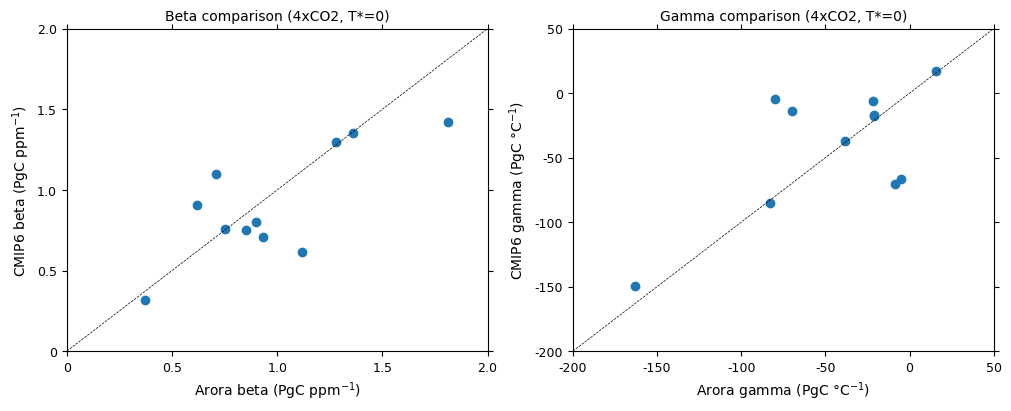

In [59]:
### Comparing beta and gamma with Arora et al. (2020)

arora_beta_4xCO2 = np.array([0.37, 1.81, 1.28, 0.90, 1.36, 0.62, 1.12, 0.71, 0.93, 0.85, 0.75])
arora_gamma_4xCO2 = np.array([-21.1, -163.1, 15.95, -21.6, -83.11, -8.67, -69.57, -5.17, -80.06, -20.95, -38.4])

fig = plt.figure(figsize=(10,4), layout="constrained")

sub = fig.add_subplot(1, 2, 1)
sub.set_title('Beta comparison (4xCO2, T*=0)',size=10)
sub.set_xlim(0,2)
sub.set_ylim(0,2)
sub.set_xlabel('Arora beta (PgC ppm$^{-1}$)', size=10)
sub.set_ylabel('CMIP6 beta (PgC ppm$^{-1}$)', size=10)
sub.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
sub.set_xticklabels(['0', '0.5', '1.0', '1.5', '2.0'],size=9)
sub.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
sub.set_yticklabels(['0', '0.5', '1.0', '1.5', '2.0'],size=9)
sub.scatter(arora_beta_4xCO2,cmip6_beta[0:11])
sub.plot([0,2],[0,2],'k--', lw=0.5)

sub = fig.add_subplot(1, 2, 2)
sub.set_title('Gamma comparison (4xCO2, T*=0)',size=10)
sub.set_xlim(-200,50)
sub.set_ylim(-200,50)
sub.set_xlabel('Arora gamma (PgC °C$^{-1}$)', size=10)
sub.set_ylabel('CMIP6 gamma (PgC °C$^{-1}$)', size=10)
sub.set_xticks([-200, -150, -100, -50, 0, 50])
sub.set_xticklabels(['-200', '-150', '-100', '-50', '0', '50'],size=9)
sub.set_yticks([-200, -150, -100, -50, 0, 50])
sub.set_yticklabels(['-200', '-150', '-100', '-50', '0', '50'],size=9)
plt.scatter(arora_gamma_4xCO2,cmip6_gamma[0:11])
sub.plot([-200,50],[-200,50],'k--', lw=0.5)